In [6]:
import sys
import math
import warnings

import psycopg2
import wrds
import gzip

import seaborn as sns
import os
import quandl
import json
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import functools
import requests
import io

import urllib.request
from urllib.error import HTTPError
# from html_table_parser.parser import HTMLTableParser
from bs4 import BeautifulSoup
import re

import plotnine as p9
from plotnine import ggplot, scale_x_date, guides, guide_legend, geom_bar, scale_y_continuous, \
    scale_color_identity, geom_line, geom_point, labs, theme_minimal, theme, element_blank, element_text, \
        geom_ribbon, geom_hline, aes, scale_size_manual, scale_color_manual, ggtitle, facet_wrap

from datetime import datetime
import datetime

import pandas as pd
# import pandas_market_calendars as mcal
from pandas.plotting import autocorrelation_plot
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import scipy as sp
from scipy.stats import norm
import scipy.stats as stats

from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from collections import deque
from bisect import insort, bisect_left
from itertools import islice

In [7]:
calls_filepath = 'calls.csv'
puts_filepath = 'puts.csv'
calls_df = pd.read_csv(calls_filepath)
puts_df = pd.read_csv(puts_filepath)

In [8]:
calls_df

,date_x,exdate,last_date_x,cp_flag,strike_price,best_bid_x,best_offer_x,volume_x,open_interest_x,impl_volatility_x,...,vega_x,theta_x,expiry_indicator_x,close_x,adj_open_x,adj_close_x,adj_volume_x,TTE_x,close_date,is_present
0,2018-01-02,2018-01-31,2018-01-02,C,269.0,2.11,2.16,477.0,37.0,0.068871,...,30.21236,-15.22501,w,268.77,242.053393,242.893856,86655749.0,29,2018-01-23,True
1,2018-01-03,2018-02-02,2018-01-03,C,270.0,2.65,2.69,289.0,719.0,0.072398,...,30.55966,-15.81073,w,270.47,243.065564,244.430187,90070416.0,30,2018-01-24,True
2,2018-01-04,2018-02-02,2018-01-04,C,272.0,2.13,2.17,769.0,6178.0,0.071179,...,30.54542,-15.79170,w,271.61,245.089905,245.460432,80595402.0,29,2018-01-25,True
3,2018-01-05,2018-02-02,2018-01-05,C,273.0,2.60,2.66,1387.0,1307.0,0.074068,...,29.90136,-16.79527,w,273.42,246.273783,247.096172,83468662.0,28,2018-01-26,False
4,2018-01-08,2018-02-07,2018-01-08,C,275.0,1.93,1.94,924.0,3846.0,0.072545,...,31.12119,-15.69601,w,273.92,246.996762,247.548034,57288979.0,30,2018-01-29,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,2023-02-22,2023-03-24,2023-02-22,C,399.0,9.08,9.12,1875.0,344.0,0.202075,...,45.10776,-66.59158,w,398.54,393.496030,392.530807,83574386.0,30,2023-02-28,True
1294,2023-02-23,2023-03-24,2023-02-23,C,401.0,8.79,8.82,936.0,923.0,0.196720,...,44.17986,-66.44084,w,400.66,395.505271,394.618841,95842681.0,29,2023-02-28,True
1295,2023-02-24,2023-03-24,2023-02-24,C,396.0,9.05,9.08,1151.0,225.0,0.201088,...,43.16854,-68.26598,w,396.38,389.457850,390.403375,108144866.0,28,2023-02-28,True
1296,2023-02-27,2023-03-31,2023-02-27,C,398.0,8.92,8.96,976.0,5244.0,0.194675,...,46.44293,-62.65579,m,397.73,393.840753,391.733020,80318244.0,32,2023-02-28,True


In [12]:
# Add a 'type' column to distinguish between calls and puts
calls_df['Type'] = 'Calls'
puts_df['Type'] = 'Puts'

# Combine into a single DataFrame
combined_df = pd.concat([calls_df, puts_df], ignore_index=True)

# Ensure 'date_x' is in datetime format
combined_df['date_x'] = pd.to_datetime(combined_df['date_x'])
calls_df['date_x'] = pd.to_datetime(calls_df['date_x'])
puts_df['date_x'] = pd.to_datetime(puts_df['date_x'])

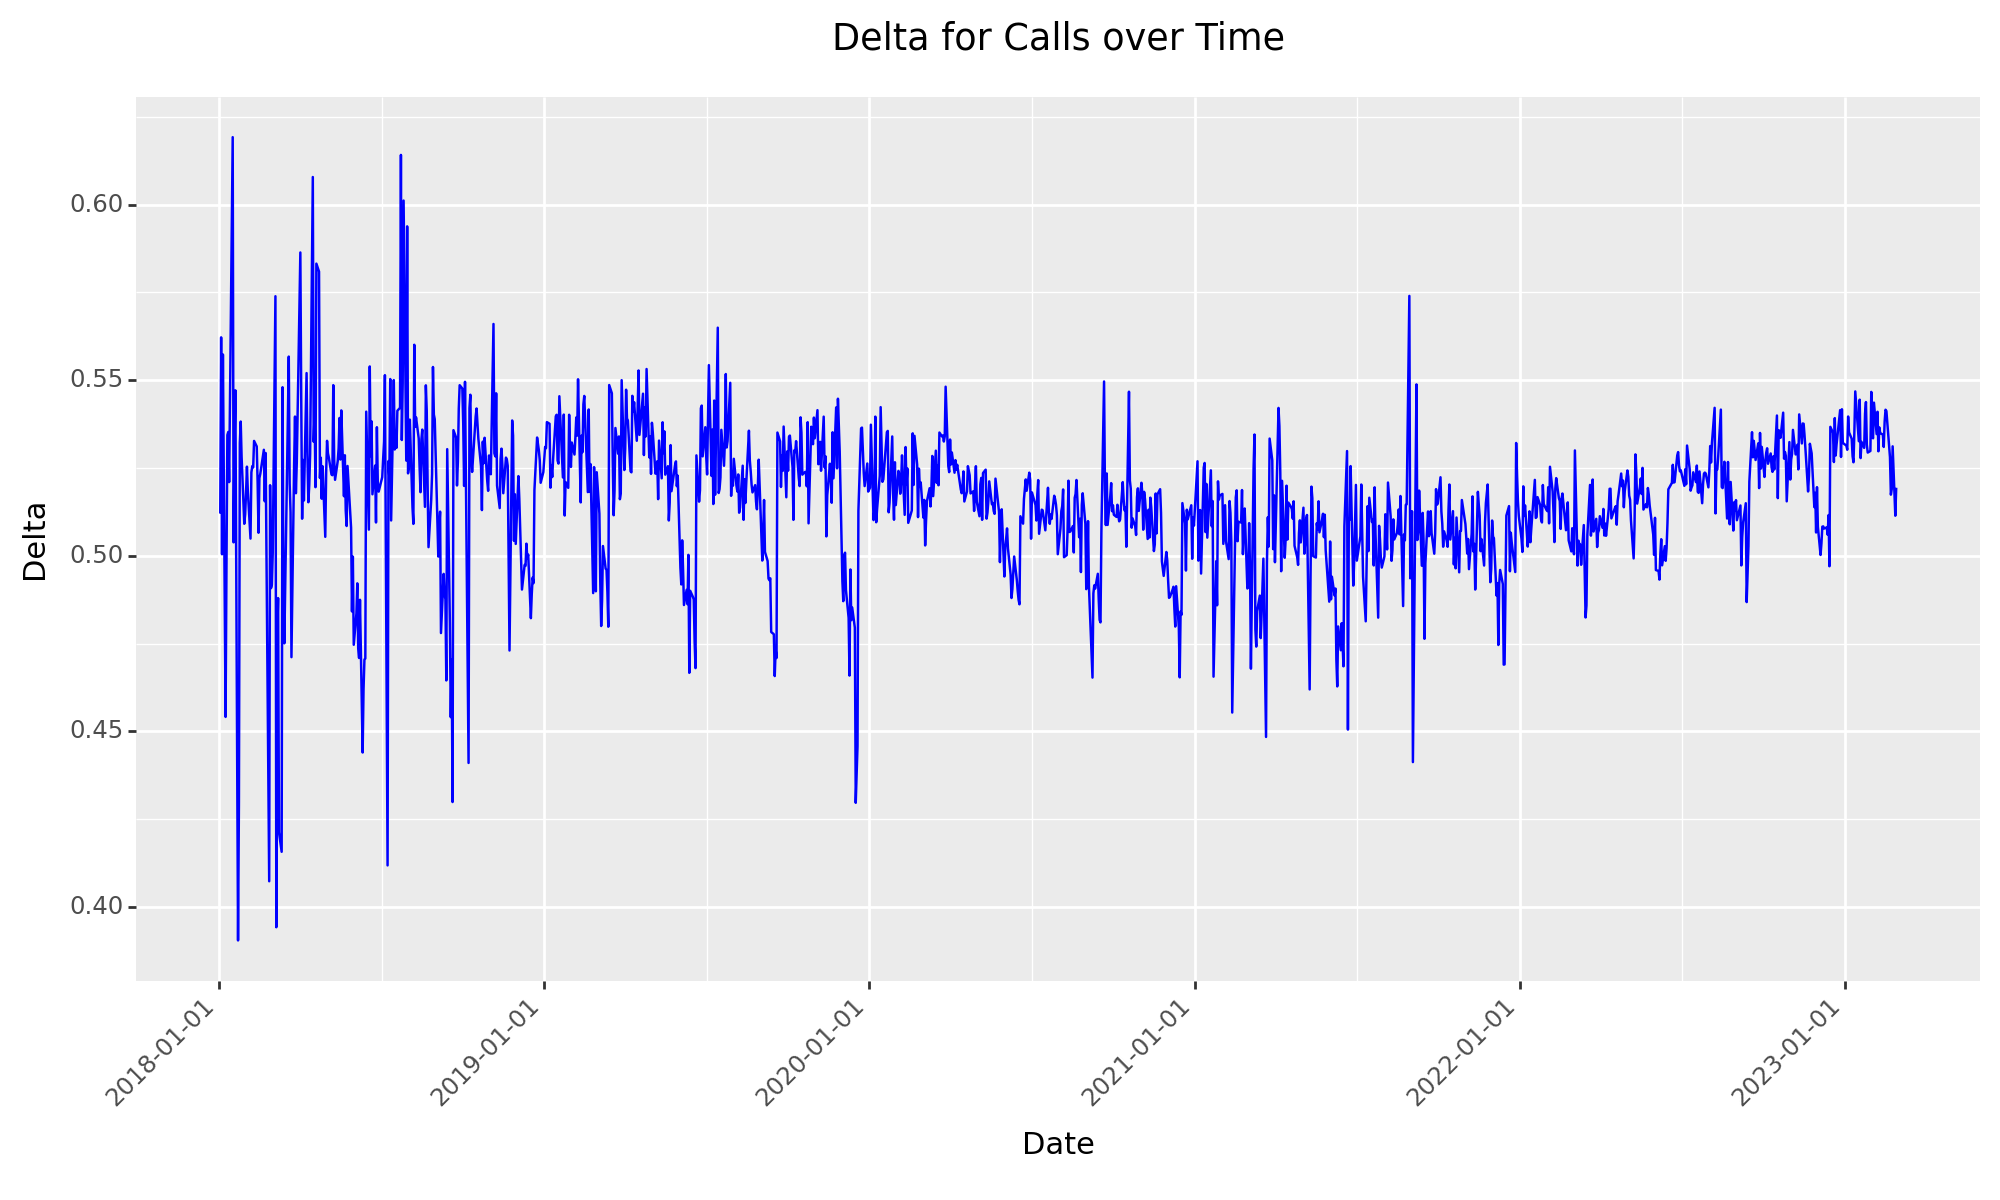

<Figure Size: (1000 x 600)>

In [14]:
p_delta_calls = (ggplot(calls_df, aes(x='date_x', y='delta_x')) +
                 geom_line(color='blue') +
                 labs(title='Delta for Calls over Time', x='Date', y='Delta', color='Type') +
                 theme(axis_text_x=element_text(rotation=45, hjust=1),
                       figure_size=(10, 6),
                       plot_title=element_text(ha='center')))
p_delta_calls

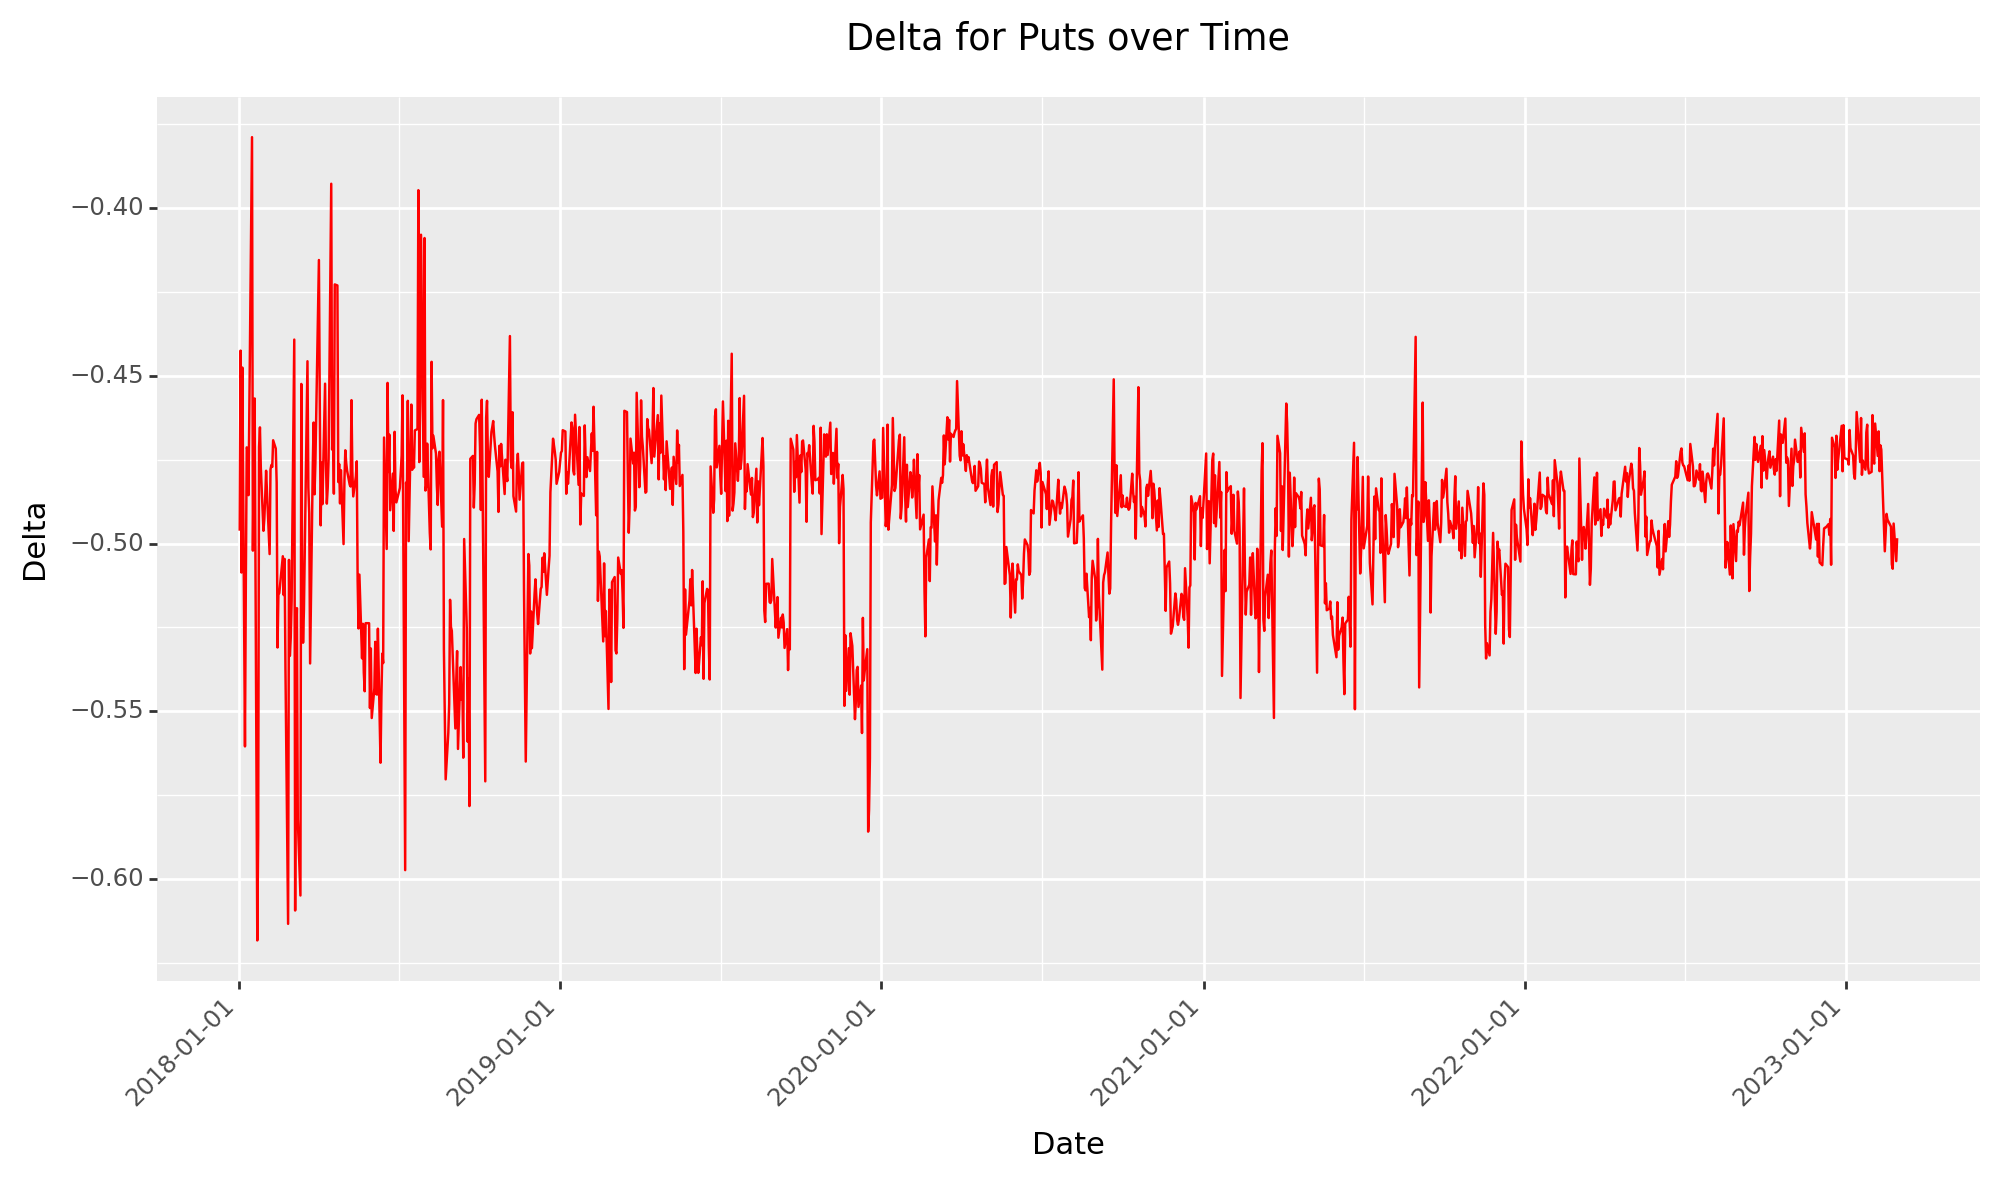

<Figure Size: (1000 x 600)>

In [15]:
p_delta_puts = (ggplot(puts_df, aes(x='date_x', y='delta_x')) +
                geom_line(color='red') +
                labs(title='Delta for Puts over Time', x='Date', y='Delta', color='Type') +
                theme(axis_text_x=element_text(rotation=45, hjust=1),
                      figure_size=(10, 6),
                      plot_title=element_text(ha='center')))
p_delta_puts

We can see that at-the-money calls and puts center around a magnitude of 0.5 delta. There also appears seasonality.

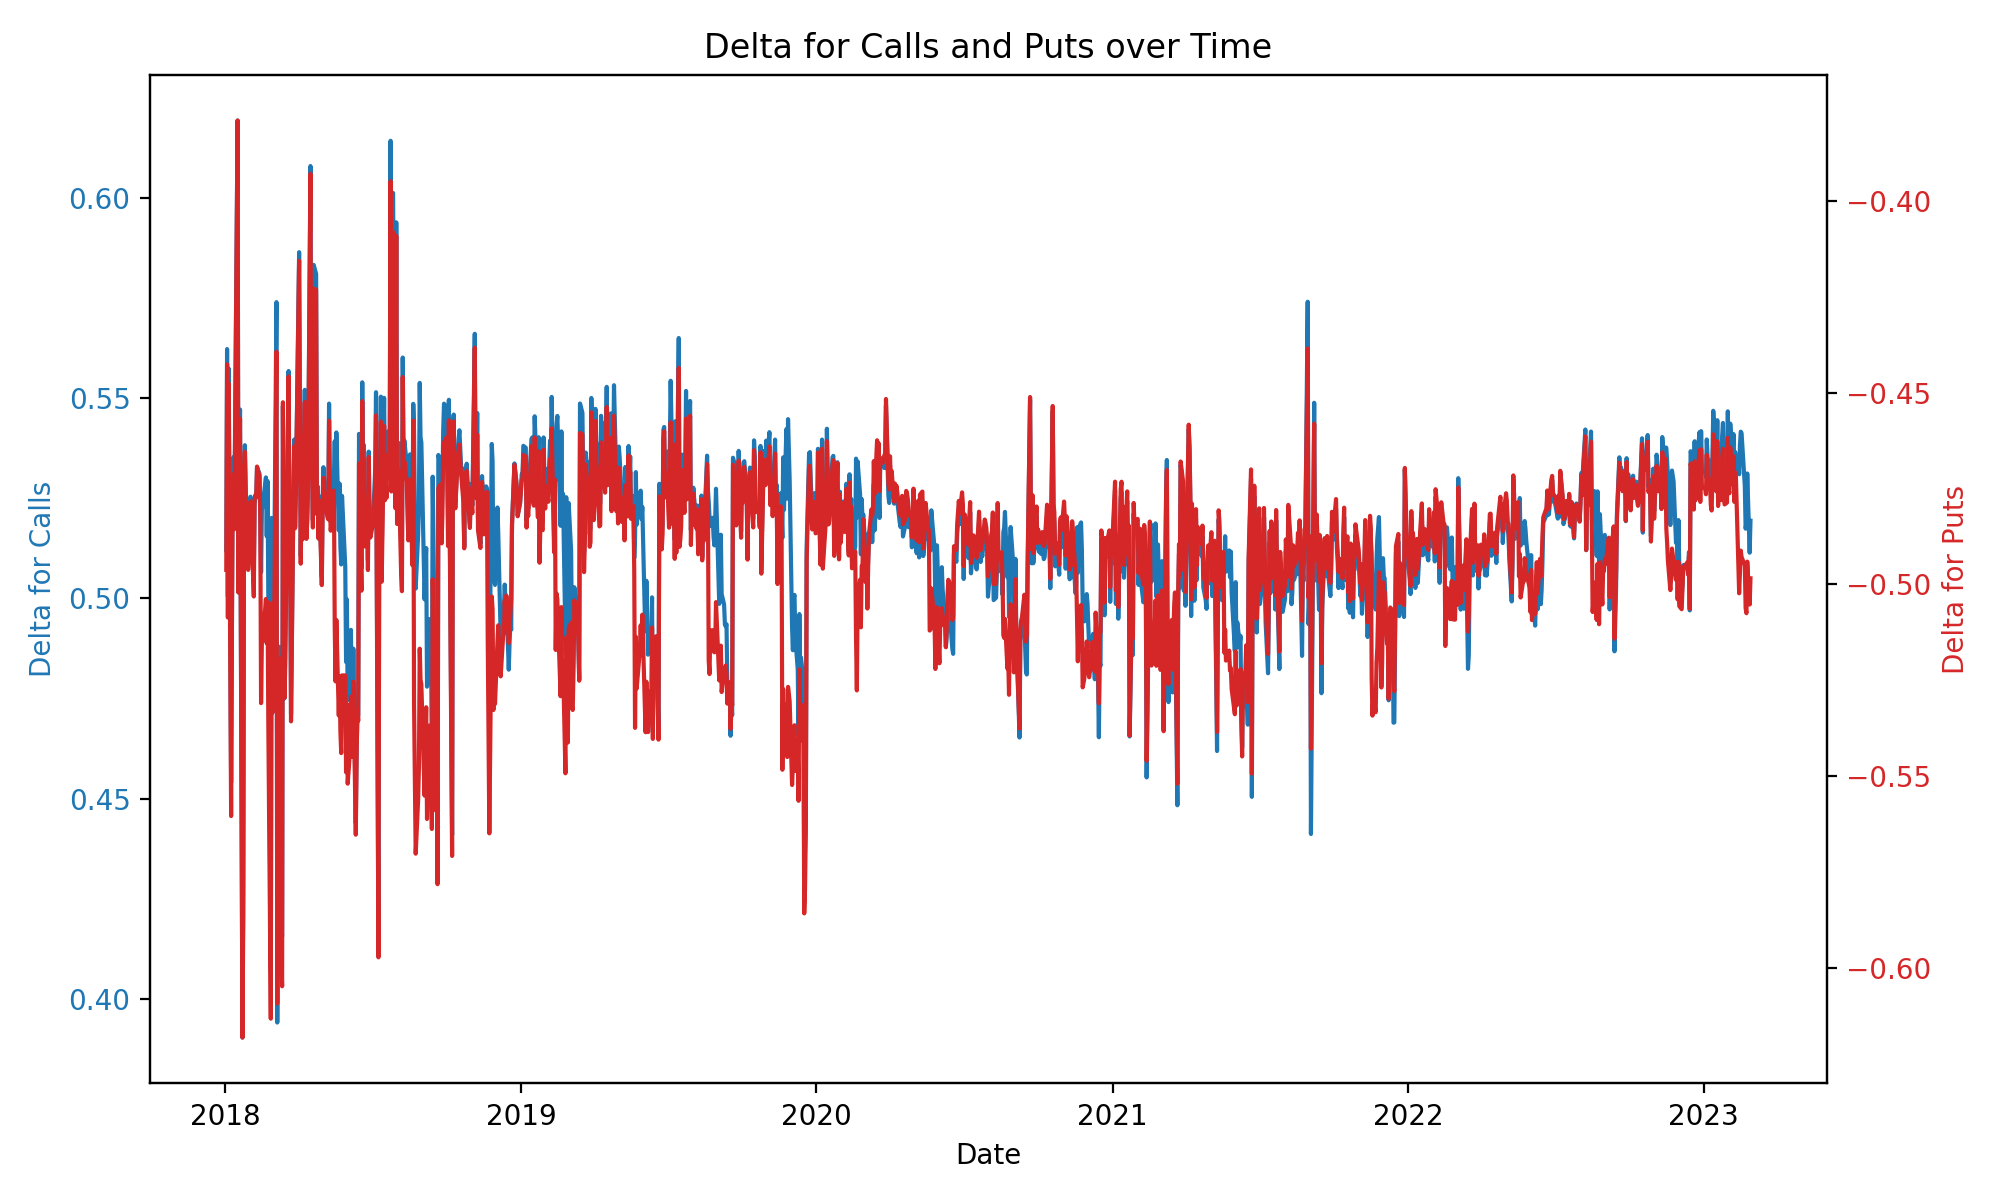

In [18]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Delta for Calls on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Delta for Calls', color=color)
ax1.plot(calls_df['date_x'], calls_df['delta_x'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Delta for Puts
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Delta for Puts', color=color)
ax2.plot(puts_df['date_x'], puts_df['delta_x'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Delta for Calls and Puts over Time')
fig.tight_layout()

plt.show()

We can see that at-the-money calls and puts have similar gamma across multiple times. There also appears to be a regime shift, where gamma is noticably lower post-COVID.

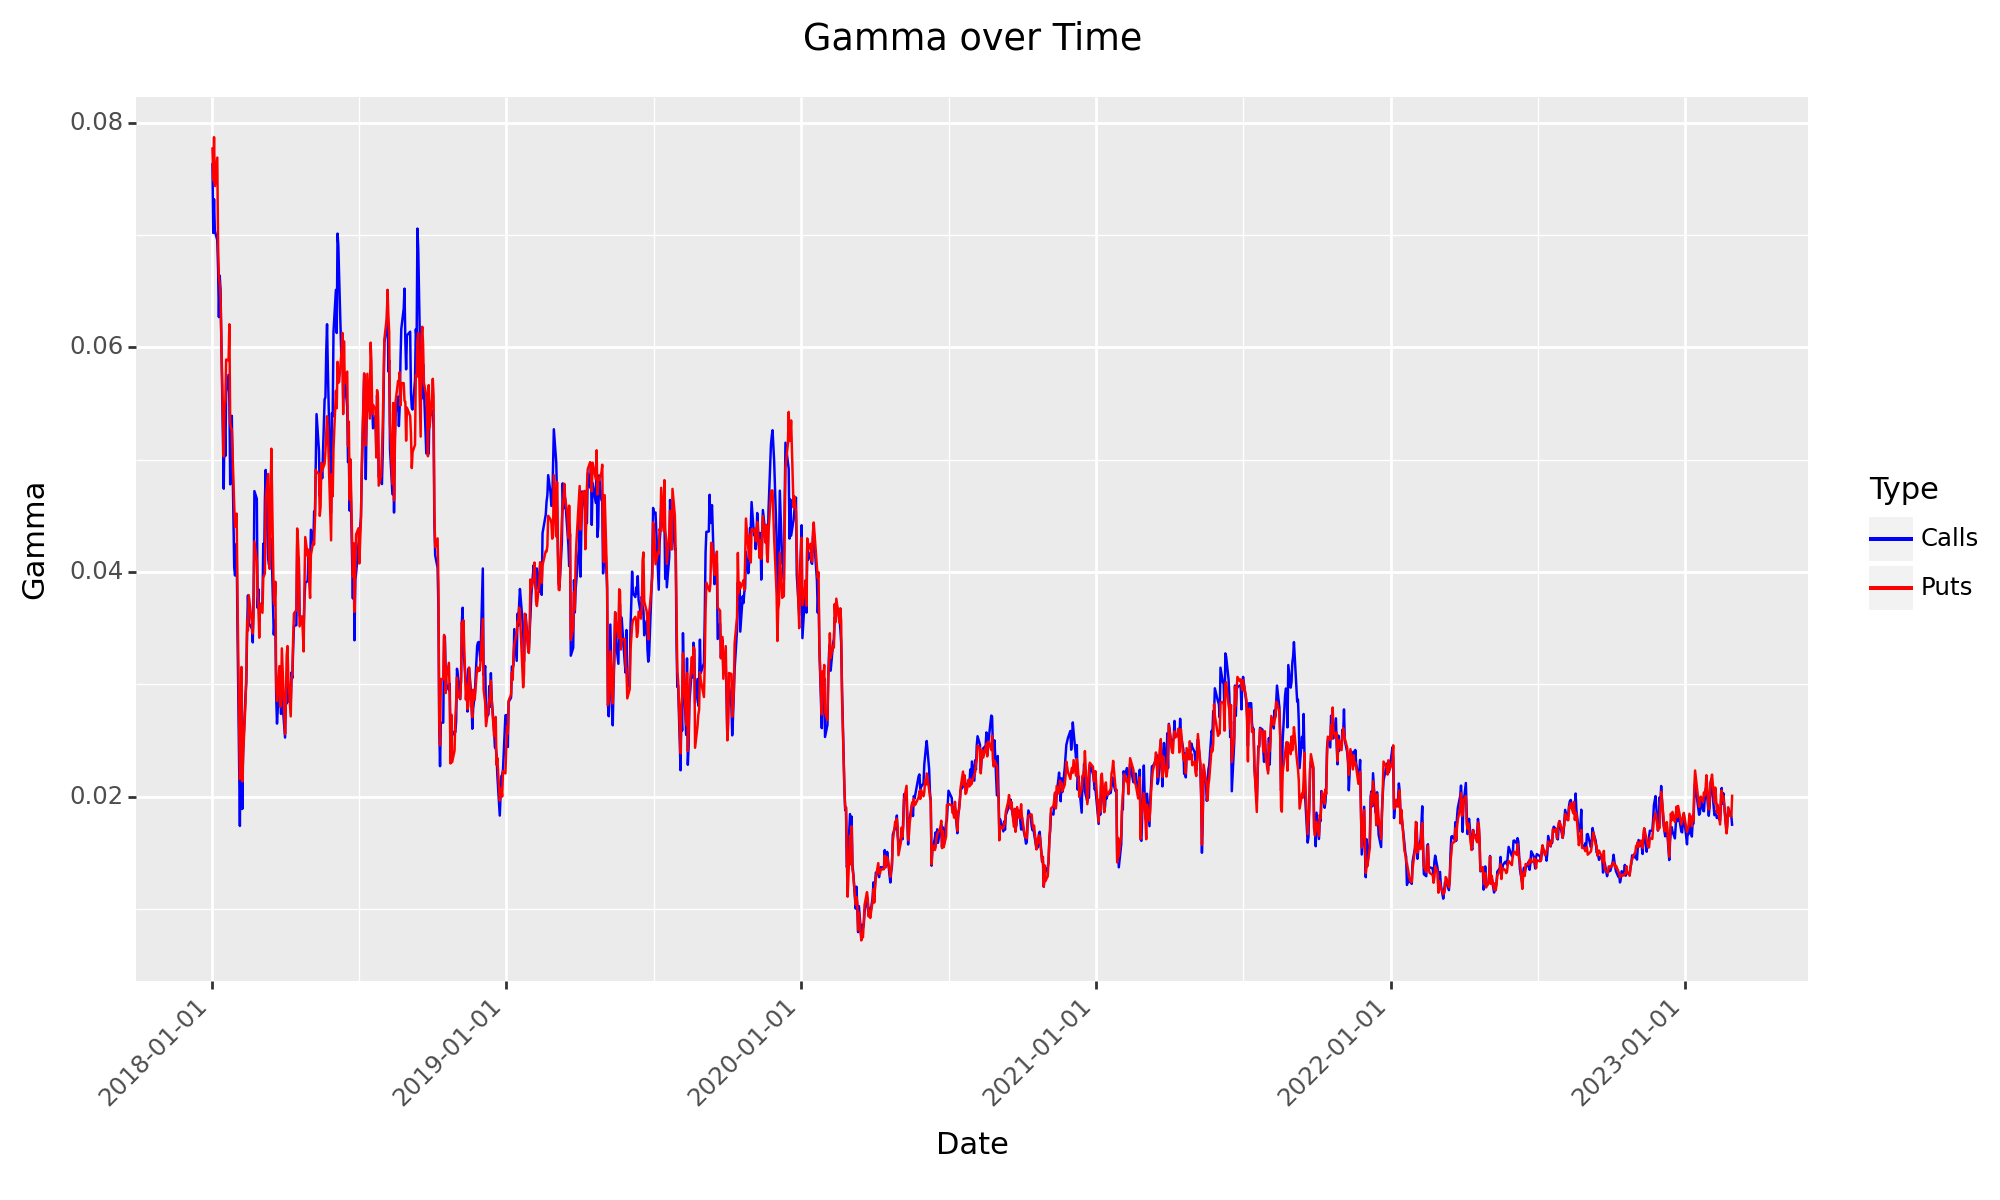

<Figure Size: (1000 x 600)>

In [16]:
p_gamma = (ggplot(combined_df, aes(x='date_x', y='gamma_x', color='type')) +
           geom_line() +
           labs(title='Gamma over Time', x='Date', y='Gamma', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Calls": "blue", "Puts": "red"}))
p_gamma

We can see that implied volatility has remained largely flat until the spike during COVID, and it has largely regressed back to pre-pandemic levels albeit perhaps slightly elevated.

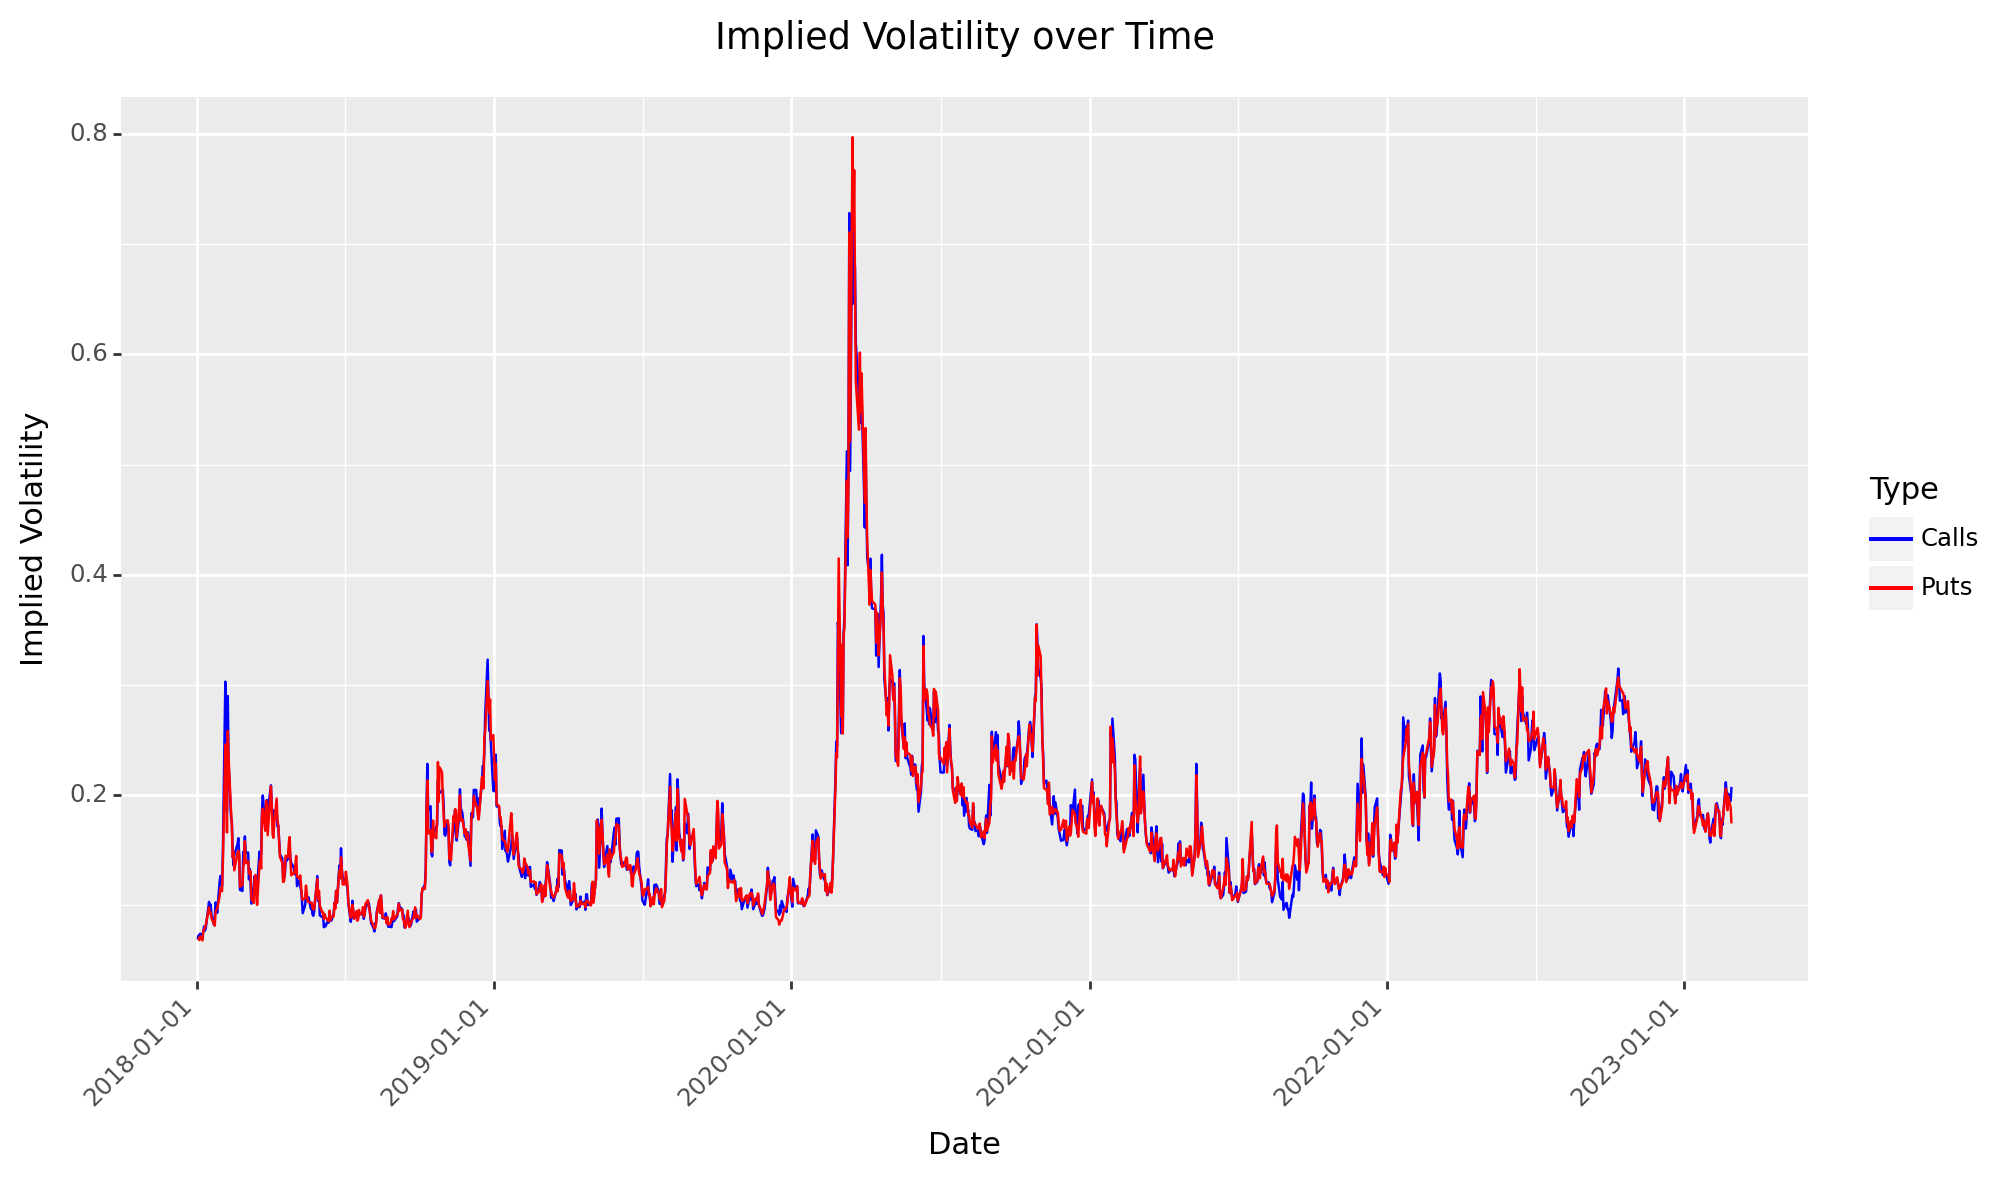

<Figure Size: (1000 x 600)>

In [19]:
p_impl_volatility = (ggplot(combined_df, aes(x='date_x', y='impl_volatility_x', color='type')) +
                     geom_line() +
                     labs(title='Implied Volatility over Time', x='Date', y='Implied Volatility', color='Type') +
                     theme(axis_text_x=element_text(rotation=45, hjust=1),
                           figure_size=(10, 6),
                           plot_title=element_text(ha='center')) +
                     scale_color_manual(values={"Calls": "blue", "Puts": "red"}))
p_impl_volatility